In [7]:
import json, time, re, collections
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from flaml.automl.automl import AutoML

In [ ]:
# Read and clean data
df = pd.read_csv("/Users/sohammandal/Developer/mlops-summer-2025/athletes.csv")

df = df[df["deadlift"].notna()].copy()

df.drop(columns=["athlete_id", "name", "region", "team", "affiliate"], inplace=True)
df.columns = df.columns.str.replace(r"[^\w]", "_", regex=True)

cat_cols = df.select_dtypes(include="object").columns
num_cols = df.select_dtypes(include=[np.number]).columns.drop("deadlift")

df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
for col in cat_cols:
    df[col] = df[col].fillna("Unknown").astype("category").cat.codes

X = df.drop(columns=["deadlift"])
y = df["deadlift"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Final feature count: {X.shape[1]}")


Final feature count: 21


In [ ]:
# FLAML AutoML All Features
settings_all = dict(
    time_budget=60,
    metric="rmse",
    task="regression",
    log_file_name="flaml_all.log"
)

automl_all = AutoML()

t0 = time.time()
automl_all.fit(X_train=X_train, y_train=y_train, **settings_all);
t_all = time.time() - t0

[flaml.automl.logger: 07-22 20:27:13] {1752} INFO - task = regression
[flaml.automl.logger: 07-22 20:27:13] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-22 20:27:13] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 07-22 20:27:13] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 07-22 20:27:13] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-22 20:27:13] {2417} INFO - Estimated sufficient time budget=1326s. Estimated necessary time budget=9s.
[flaml.automl.logger: 07-22 20:27:13] {2466} INFO -  at 0.2s,	estimator lgbm's best error=90188.8421,	best estimator lgbm's best error=90188.8421
[flaml.automl.logger: 07-22 20:27:13] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-22 20:27:13] {2466} INFO -  at 0.2s,	estimator lgbm's best error=90188.8421,	best estimator lgbm's best error=90188.8421
[flaml.automl.logger: 07-

In [ ]:
# Evaluate
y_pred_all = automl_all.predict(X_test)
rmse_all = np.sqrt(mean_squared_error(y_test, y_pred_all))

print(f"\nAll-features RMSE: {rmse_all:.2f}")
print("Best estimator:", automl_all.best_estimator)
print("Best validation loss:", automl_all.best_loss)
print(f"Elapsed time: {t_all:.1f} s")



All-features RMSE: 18411.17
Best estimator: extra_tree
Best validation loss: 46.51842925683741
Elapsed time: 60.1 s


Top 5 Features:
 backsq     0.715272
fran       0.055556
gender     0.046299
height     0.046297
pullups    0.037051
dtype: float64


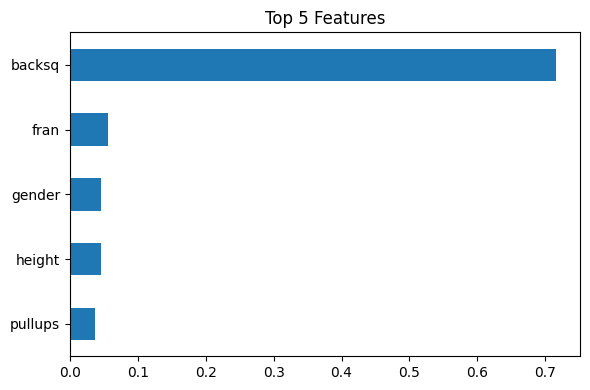

In [ ]:
best_est = automl_all.model.estimator
feat_imp = pd.Series(best_est.feature_importances_, index=X_train.columns)
top5 = feat_imp.sort_values(ascending=False).head(5)

print("Top 5 Features:\n", top5)

top5.plot(kind="barh", title="Top 5 Features", figsize=(6, 4))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# FLAML AutoML Top 3 Features

top3 = top5.index[:3]
X_top3_train = X_train[top3]
X_top3_test = X_test[top3]

automl_top3 = AutoML()
settings_top3 = {
    "time_budget": 60,
    "metric": 'rmse',
    "task": 'regression',
    "log_file_name": "flaml_top3.log",
}

t0 = time.time()
automl_top3.fit(X_train=X_top3_train, y_train=y_train, **settings_top3)
t_top3 = time.time() - t0


[flaml.automl.logger: 07-22 20:32:03] {1752} INFO - task = regression
[flaml.automl.logger: 07-22 20:32:03] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-22 20:32:03] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 07-22 20:32:03] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 07-22 20:32:03] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-22 20:32:03] {2417} INFO - Estimated sufficient time budget=1029s. Estimated necessary time budget=7s.
[flaml.automl.logger: 07-22 20:32:03] {2466} INFO -  at 0.1s,	estimator lgbm's best error=90191.0239,	best estimator lgbm's best error=90191.0239
[flaml.automl.logger: 07-22 20:32:03] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-22 20:32:03] {2466} INFO -  at 0.1s,	estimator lgbm's best error=90191.0239,	best estimator lgbm's best error=90191.0239
[flaml.automl.logger: 07-

In [ ]:
# Evaluate
y_pred_top3 = automl_top3.predict(X_top3_test)
rmse_top3 = np.sqrt(mean_squared_error(y_test, y_pred_top3))

print(f"\nTop-3-features RMSE: {rmse_top3:.2f}")
print("Best estimator (Top 3):", automl_top3.best_estimator)
print("Best validation loss (Top 3):", automl_top3.best_loss)
print(f"Elapsed time: {t_top3:.1f} s")


Top-3-features RMSE: 8234.08
Best estimator (Top 3): rf
Best validation loss (Top 3): 15014.652279745227
Elapsed time: 60.0 s


In [18]:
print("Top Models by Validation Score (All Features):")
print(json.dumps(automl_all.best_config_per_estimator, indent=2))

print("\nTop Models by Validation Score (Top 3 Features):")
print(json.dumps(automl_top3.best_config_per_estimator, indent=2))

Top Models by Validation Score (All Features):
{
  "lgbm": {
    "n_estimators": 11,
    "num_leaves": 9,
    "min_child_samples": 10,
    "learning_rate": 0.22183361212674668,
    "log_max_bin": 9,
    "colsample_bytree": 0.8529494782824861,
    "reg_alpha": 0.0021756507378400095,
    "reg_lambda": 1.0535142738716388
  },
  "rf": {
    "n_estimators": 4,
    "max_features": 0.9586055955836026,
    "max_leaves": 19
  },
  "xgboost": {
    "n_estimators": 23,
    "max_leaves": 4,
    "min_child_weight": 6.460451502502143,
    "learning_rate": 0.4839966785164543,
    "subsample": 1.0,
    "colsample_bylevel": 0.8811171114303163,
    "colsample_bytree": 0.8499027725496043,
    "reg_alpha": 0.0015851927568202393,
    "reg_lambda": 1.9570976003429281
  },
  "extra_tree": {
    "n_estimators": 6,
    "max_features": 0.8832004373332465,
    "max_leaves": 310
  },
  "xgb_limitdepth": {
    "n_estimators": 10,
    "max_depth": 5,
    "min_child_weight": 7.108570598095146,
    "learning_rate": 1

In [26]:
def get_top3_by_speed(automl):
    # Each entry in config_history: iter → (estimator, config, time)
    records = [
        {"estimator": est, "timestamp": t}
        for _, (est, _, t) in automl.config_history.items()
    ]
    df = pd.DataFrame(records)
    fastest = df.groupby("estimator")["timestamp"].min().sort_values().head(3)
    return fastest

# For all features
top3_fast_all = get_top3_by_speed(automl_all)
print("Top 3 Fastest Models (All Features):")
print(top3_fast_all)

# For top-3 features
top3_fast_top3 = get_top3_by_speed(automl_top3)
print("\nTop 3 Fastest Models (Top 3 Features):")
print(top3_fast_top3)


Top 3 Fastest Models (All Features):
estimator
lgbm          0.178433
xgboost       0.835000
extra_tree    0.890501
Name: timestamp, dtype: float64

Top 3 Fastest Models (Top 3 Features):
estimator
lgbm    0.079187
rf      0.745802
Name: timestamp, dtype: float64


## FLAML AutoML Summary Report

### Platform Type

**FLAML is a full-code AutoML platform.**
**Reason:** It requires writing Python code to load data, configure and run the AutoML process, and extract model outputs. There is no graphical interface or drag-and-drop setup, so it does not qualify as no-code or low-code.

---

### FLAML AutoML Training Summary

#### All Features:

* **Best Estimator:** `extra_tree`
* **Test RMSE:** 18,411.17
* **Best Validation Loss:** 46.52
* **Time to Best Model:** 60.1 seconds

#### Top 3 Features Only:

* **Best Estimator:** `rf`
* **Test RMSE:** 8,234.08
* **Best Validation Loss:** 15,014.65
* **Time to Best Model:** 60.0 seconds

---

### Key Insights

* Using all features resulted in **lower validation loss** and **higher test RMSE**, likely due to regularization/generalization tradeoff.
* `ExtraTreesRegressor` performed best overall when using all features.
* `RandomForest` was top when using only 3 features, but with higher error.
* Feature reduction led to a **performance tradeoff**, despite comparable training time.
* Model speed rankings stayed mostly consistent regardless of feature count.

---

### Top 3 Fastest Models by Training Time

#### All Features:

| Estimator    | Time (s) |
| ------------ | -------- |
| `lgbm`       | 0.178    |
| `xgboost`    | 0.835    |
| `extra_tree` | 0.891    |

#### Top 3 Features:

| Estimator | Time (s) |
| --------- | -------- |
| `lgbm`    | 0.079    |
| `rf`      | 0.746    |

**Summary:**
`lgbm` was the fastest model overall across both setups (as low as 0.08s), followed by `xgboost` and `extra_tree` for all features, and `rf` when using top 3 features.

---

### Comparison to Previous Assignments

| Model                        | RMSE          | R²   |
| ---------------------------- | ------------- | ---- |
| Assignment 1 (v1\_n100\_d5)  | 45,177.14     | 0.56 |
| Assignment 2 (v1\_n200\_d10) | 48,877.99     | 0.48 |
| FLAML (All Features)         | **18,411.17** | ↑    |
| FLAML (Top 3 Features)       | **8,234.08**  | ↑    |

**Conclusion:**
- FLAML outperformed all models from Assignments 2 in terms of RMSE, demonstrating its advantage in both accuracy and optimization efficiency. The improvement is especially noticeable using the full feature set.
- Assignment 1 was not considered since it predicts `total_lift` instead of `deadlift`